In [ ]:
import pandas as pd
pd.set_option('max_colwidth', 70)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

lambda_rate = 5000  # average rate of swaps per unit time
mu_rate = 3000  # average rate of liquidity additions per unit time
nu_rate = 500  # average rate of liquidity removals per unit time
TIMESTEPS=10000
RUNS=5

state = {
    'DAI_balance': 60000000,
    'ETH_balance': 30000,
    'addliquidity_ETH':200,
    'addliquidity_DAI':2000,
    'current_price':2000
}
state['LP_shares'] = state['ETH_balance']
params = {
    'lower_tick_price':[2000],
    'upper_tick_price':[2500],
    'volatility':[0.5,1],
    'fee_numerator': [997],
    'fee_denominator': [1000]
}

#Add liquidity
def addLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    eth_reserve = int(current_state['ETH_balance'])
    liquidity_minted = int(input_['eth_deposit'] * total_liquidity // eth_reserve)
    return ('LP_shares', total_liquidity + liquidity_minted)

def addLiquidity_ETH(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + input_['eth_deposit'])

def addLiquidity_DAI(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if input_['eth_deposit'] == 0:
        token_amount = 0
    else:
        token_amount = int(input_['eth_deposit'] * token_reserve // eth_reserve + 1)
    return ('DAI_balance', token_reserve + token_amount)


#Remove liquidity
def removeLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    amount = int(input_['LP_burn'])
    return ('LP_shares', int(total_liquidity - amount))

def removeLiquidity_ETH(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    eth_reserve = int(current_state['ETH_balance'])
    amount = int(input_['LP_burn'])
    eth_amount = int(amount * eth_reserve // total_liquidity)
    return ('ETH_balance', int(eth_reserve - eth_amount))

def removeLiquidity_DAI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    token_reserve = int(current_state['DAI_balance'])
    amount = int(input_['LP_burn'])
    token_amount = int(amount * token_reserve // total_liquidity)
    return ('DAI_balance', int(token_reserve - token_amount))

#Price(Helper function)
def getInputPrice(input_amount, input_reserve, output_reserve, params):
    fee_numerator = params['fee_numerator']
    fee_denominator = params['fee_denominator']
    input_amount_with_fee = input_amount * fee_numerator
    numerator = input_amount_with_fee * output_reserve
    denominator = (input_reserve * fee_denominator) + input_amount_with_fee
    return int(numerator // denominator)

#Swap ETH-token
#Eth sold/deposited
def ethToToken_ETH(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + eth_sold)

#DAI received
def ethToToken_DAI(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if eth_sold == 0:
        return ('DAI_balance', token_reserve)
    else:
        tokens_bought = int(getInputPrice(eth_sold, eth_reserve, token_reserve, params))
        return ('DAI_balance', token_reserve - tokens_bought)

 #Swap token-ETH
 #Eth recieved   
def tokenToEth_ETH(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    if tokens_sold == 0:
        return ('ETH_balance', eth_reserve)
    else:
        token_reserve = int(current_state['DAI_balance'])
        eth_bought = int(getInputPrice(tokens_sold, token_reserve, eth_reserve, params))
        return ('ETH_balance', eth_reserve - eth_bought)

 #tokens sold/depoisted   
def tokenToEth_DAI(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    token_reserve = int(current_state['DAI_balance'])
    return ('DAI_balance', token_reserve + tokens_sold)


import random
def actionDecoder(params, step, history, current_state):
    
    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
        
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'eth_sold': 0,
        'tokens_sold': 0,
        'eth_deposit': 0,
        'LP_burn': 0,        
    }
    
    # Generate a random event
    events = ['TokenPurchase', 'EthPurchase', 'AddLiquidity', 'Transfer']
    event = random.choice(events)
    
    action['action_id'] = event
    
    if event == 'TokenPurchase':
        # Set random values for eth_sold
        action['eth_sold'] = random.uniform(0, 20)*params['adoption_scnarios']
    elif event == 'EthPurchase':
        # Set random values for tokens_sold
        action['tokens_sold'] = random.uniform(0, 10)
    elif event == 'AddLiquidity':
        # Set random values for eth_deposit
        action['eth_deposit'] = random.uniform(0, 10)*params['adoption_scnarios']
    elif event == 'Transfer':
        # Set random values for UNI_burn
        action['LP_burn'] = random.uniform(0, 10)

    return action
def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_DAI(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_DAI(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_DAI(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', current_state['DAI_balance'])
    
def mechanismHub_ETH(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_ETH(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_ETH(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_ETH(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_ETH(params, step, history, current_state, input_)
    return('ETH_balance', current_state['ETH_balance'])

def mechanismHub_LP(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'AddLiquidity':
        return addLiquidity_LP(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_LP(params, step, history, current_state, input_)
    return('LP_shares', current_state['LP_shares'])
    

partial_state_update_blocks = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ETH_balance': mechanismHub_ETH,
            'LP_shares': mechanismHub_LP
        }
    }
]
# Simulation Parameters
sim_config = {
    'N': RUNS,
    'T': range(TIMESTEPS),
    'M': params
}
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)
plt.figure(figsize=(20, 20))
plt.subplot(4, 1, 1)
plt.plot(df['timestep'], df['DAI_balance'])
plt.xlabel('Time Step')
plt.ylabel('DAI Balance')

plt.subplot(4, 1, 2)
plt.plot(df['timestep'], df['ETH_balance'])
plt.xlabel('Time Step')
plt.ylabel('ETH balance')

plt.subplot(4, 1, 3)
plt.plot(df['timestep'], df['LP_shares'])
plt.xlabel('Time Step')
plt.ylabel('LP supply')


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 3, 5, 8)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 3, 5, 8)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 7.96s


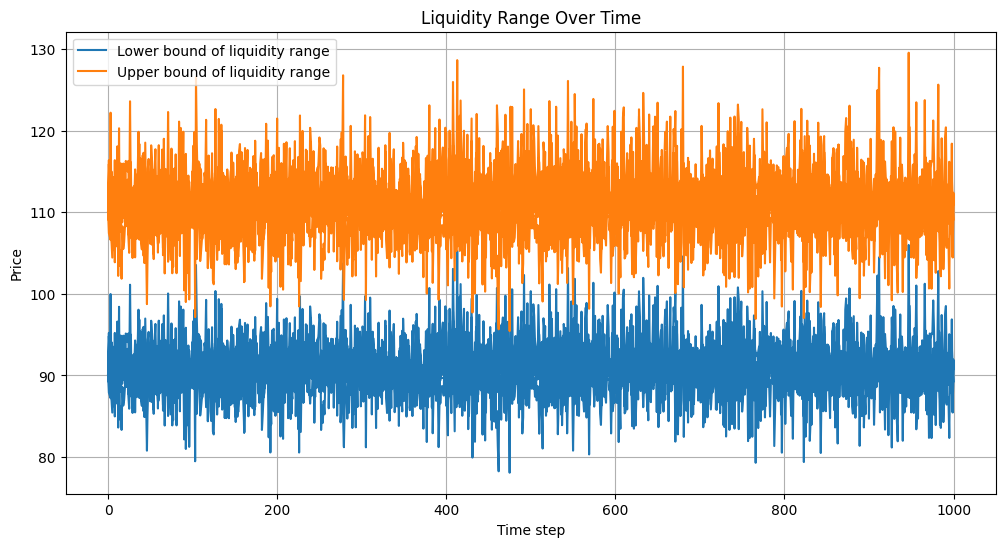

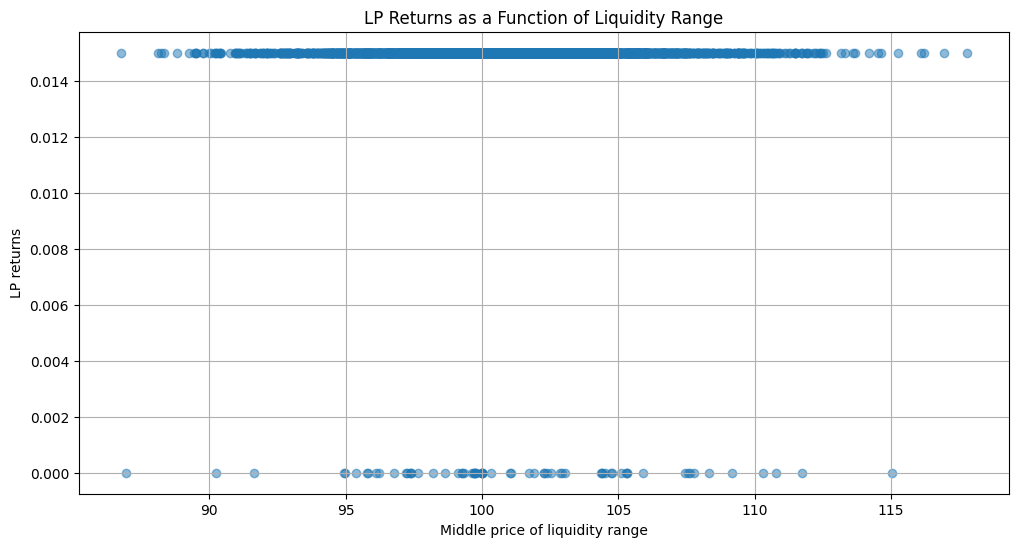

In [16]:
import pandas as pd
pd.set_option('max_colwidth', 70)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

TIMESTEPS=1000
RUNS=1

#State update functions
state = {
    'price': 100,  # the current price of the asset
    'volatility': 0.2,  # the volatility of the asset
    'liquidity_range': (90, 110),  # the price range where the LP is providing liquidity
    'investment': 10000,  # the LP's initial investment
    'liquidity_provided': 10000,  # the amount of liquidity the LP is providing
    'returns': 0,  # the returns of the LP
    'fee_rate': 0.003,  # the fee rate (e.g., 0.3% for most Uniswap V3 pools)
    'trading_volume': 50000,  # the total trading volume within the LP's
}

#Parameters
# Parameters
params = {
    'drift': [1],  # the expected return of the asset
    'time_step': [0.01],  # the time step for the GBM model
    'volatility': [0.1, 0.2, 0.3, 0.4, 0.5]  # the volatility of the asset
}

# Policy Function
def range_policy(params, step, sH, s):
    price = s['price']
    drift = params['drift']
    time_step = params['time_step']
    volatility = params['volatility']  # use the volatility parameter instead of the state variable
    
    # estimate the future price using GBM
    future_price = price * np.exp((drift - 0.5 * volatility**2) * time_step + volatility * np.sqrt(time_step) * np.random.normal())
    
    # adjust the liquidity range to be centered around the estimated future price
    liquidity_range = (future_price * 0.9, future_price * 1.1)
    
    return {'liquidity_range': liquidity_range}

#State update function
def update_range(params, step, sH, s, _input):
    y = 'liquidity_range'
    x = _input['liquidity_range']
    return (y, x)

# Policy function
def calculate_returns(params, step, sH, s):
    price = s['price']
    investment = s['investment']
    liquidity_range = s['liquidity_range']
    liquidity_provided = s['liquidity_provided']
    fee_rate = s['fee_rate']
    trading_volume = s['trading_volume']
    
    # calculate the returns based on the fees earned from trades within the liquidity range
    if liquidity_range[0] <= price <= liquidity_range[1]:
        fees_earned = trading_volume * fee_rate * (liquidity_provided / investment)
        returns = fees_earned / investment
    else:
        returns = 0  # the LP earns no fees if the price is outside their specified range
    
    return {'returns': returns}

def update_returns(params, step, sH, s, _input):
    y = 'returns'
    x = _input['returns']
    return (y, x)


#PSUBS
partial_state_update_blocks = [
    {
        'policies': {
            'adjust_liquidity_range': range_policy,
            'calculate_returns': calculate_returns
        },
        'variables': {
            'liquidity_range': update_range,
            'returns': update_returns
        }
    }
]

# Simulation Parameters
sim_config = {
    'N': RUNS,
    'T': range(TIMESTEPS),
    'M': params
}
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)
#plot results

# Extract the upper and lower bounds of the liquidity range at each time step
df['liquidity_range_lower'] = df['liquidity_range'].apply(lambda x: x[0])
df['liquidity_range_upper'] = df['liquidity_range'].apply(lambda x: x[1])

# Plot the upper and lower bounds of the liquidity range
plt.figure(figsize=(12, 6))
plt.plot(df['timestep'], df['liquidity_range_lower'], label='Lower bound of liquidity range')
plt.plot(df['timestep'], df['liquidity_range_upper'], label='Upper bound of liquidity range')
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Price')
plt.title('Liquidity Range Over Time')
plt.grid(True)
plt.show()
#Plot Returns
df['liquidity_range_middle'] = df['liquidity_range'].apply(lambda x: (x[0] + x[1]) / 2)
plt.figure(figsize=(12, 6))
plt.scatter(df['liquidity_range_middle'], df['returns'], alpha=0.5)
plt.xlabel('Middle price of liquidity range')
plt.ylabel('LP returns')
plt.title('LP Returns as a Function of Liquidity Range')
plt.grid(True)
plt.show()


In [14]:
!pip install seaborn


You should consider upgrading via the 'c:\users\hijaz tr\desktop\cadcadproject1\abcde\scripts\python.exe -m pip install --upgrade pip' command.
